# A.1. Data Curation
## Alyson Suchodolski

The necessary imports are below

In [1]:
import sys

import json
import requests

import numpy as np
import pandas as pd
import datetime as dt

from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt

# Step 1: Data Aquisition

We use two Wikimedia API endpoints to access the data we need:
1. https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
2. https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

## Retrieving Legacy Data

In [3]:
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2021100100"
                    }

mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                # for end use 1st day of month following final month of data
                 "end" : "2021100100"
                    }

## Retrieving Pageview Data

In [4]:
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021101000'
                        }

mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021101000'
                        }

mobile_web_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    # for end use 1st day of month following final month of data
                    "end" : '2021101000'
                        }

## Creating the Call to Pull the Data
### Then calling the function

In [5]:
# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/ams884',
    'From': 'ams884@uw.edu'
}

In [6]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [7]:
desktop_params_monthly_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews)
mobile_app_params_monthly_pageviews = api_call(endpoint_pageviews, mobile_app_params_pageviews)
mobile_web_params_monthly_pageviews = api_call(endpoint_pageviews, mobile_web_params_pageviews)

In [8]:
desktop_monthly_legacy = api_call(endpoint_legacy, desktop_params_legacy)
mobile_monthly_legacy = api_call(endpoint_legacy, mobile_params_legacy)

## Saving the data in JSON files

In [9]:
# Parse JSON
with open('pagecounts_desktop-site_200712-202108.json', 'w') as outfile:
    json.dump(desktop_monthly_legacy, outfile)
    
# Parse JSON
with open('pagecounts_mobile-site_200712-202108.json', 'w') as outfile:
    json.dump(mobile_monthly_legacy, outfile)

# Parse JSON
with open('pageviews_desktop_201507-202109.json', 'w') as outfile:
    json.dump(desktop_params_monthly_pageviews, outfile)

# Parse JSON
with open('pageviews_mobile-app_201507-202109.json', 'w') as outfile:
    json.dump(mobile_app_params_monthly_pageviews, outfile)

# Parse JSON
with open('pageviews_mobile-web_201507-202109.json', 'w') as outfile:
    json.dump(mobile_web_params_monthly_pageviews, outfile)

# Step 2: Data Processing
Now we need to clean the data to make it functional for analysis.

First, create default, dictionaries that we will add to

In [10]:
mobile_monthly_pageviews = defaultdict(int)
desktop_monthly_pageviews = defaultdict(int)

mobile_monthly_pagecounts = defaultdict(int)
desktop_monthly_pagecounts = defaultdict(int)

Set up functions that can then grab the month and year pieces of the timestamp

In [11]:
def yyyy(timestamp):
    return int(timestamp[:4])

def mm(timestamp):
    return int(timestamp[4:6])

def yyyymm(timestamp):
    return str(yyyy(timestamp)) + str(mm(timestamp)).rjust(2, "0")

The next two functions are used as followed:
1. add_counts aggregates the views so that they are grouped by YYYYMM
2. make_df converts these dictionaries into dataframes

In [12]:
def add_counts(st_dict, fin_dict):
    for item in st_dict['items']:
        key = yyyymm(item['timestamp'])
        if 'views' in item:
            fin_dict[key] += item['views']
        else:
            fin_dict[key] += item['count']
            
def make_df(dicty, valkey):
    return pd.DataFrame({'yyyymm': list(dicty.keys()), valkey: list(dicty.values())})

Now we use the first function to begin adding to the blank dictionaries
Note: We want to combine mobile app views with mobile web views into the same dictionary

In [13]:
add_counts(mobile_app_params_monthly_pageviews, mobile_monthly_pageviews)
add_counts(mobile_web_params_monthly_pageviews, mobile_monthly_pageviews)

add_counts(desktop_params_monthly_pageviews, desktop_monthly_pageviews)
add_counts(mobile_monthly_legacy, mobile_monthly_pagecounts)
add_counts(desktop_monthly_legacy, desktop_monthly_pagecounts)

We now want to turn these updated dictionaries into dataframes

In [14]:
pageview_mobile = make_df(mobile_monthly_pageviews, 'pageview_mobile_views')
pagecount_mobile = make_df(mobile_monthly_pagecounts, 'pagecount_mobile_views')

pageview_desktop = make_df(desktop_monthly_pageviews, 'pageview_desktop_views')
pagecount_desktop = make_df(desktop_monthly_pagecounts, 'pagecount_desktop_views')

Since it would be best if all the data is located in one file, we will merge the previous dataframes into one master df

In [15]:
df = pageview_mobile.merge(pagecount_mobile, on='yyyymm', how='outer')

df = df.merge(pageview_desktop, on='yyyymm', how='outer')

df = df.merge(pagecount_desktop, on='yyyymm', how='outer')

We now have to do the following steps:
1. Create new columns for an accumulation of views and counts
2. Separate the timestamp into Month and Year
3. Drop the timestamp column

In [16]:
df['pagecount_all_views'] = df['pagecount_mobile_views'] + df['pagecount_desktop_views']
df['pageview_all_views'] = df['pageview_mobile_views'] + df['pageview_desktop_views']
df['year'] = df.yyyymm.apply(str).apply(yyyy)
df['month'] = df.yyyymm.apply(str).apply(mm)

df.drop('yyyymm', axis=1, inplace=True)

Finally we can write out the master df into a single csv file

In [17]:
df.to_csv('en-wikipedia_traffic_200712-202108.csv', index=False)

# Step 3: Data Analysis
Our final step is analyzing the data. We will do this by visualizing the dataset as a time series graph.
We want to track mobile, desktop, and all traffic. Since we are looking at both counts and views, there will be 6 lines to keep track of on the graph. On top of that, the timelines for each api endpoint are different, but there is an overlapping year of data.

We will now read in the same csv file we just created

In [18]:
df = pd.read_csv('en-wikipedia_traffic_200712-202108.csv')
df = df.replace(to_replace=0, value=np.nan)

In [19]:
df['date'] = df.apply(lambda r: dt.datetime(int(r.year), int(r.month), 1), axis=1)
df = df.sort_values('date')

Now we will plot the graph we want. This will involve:
1. Plotting both the pageviews and pagecounts
2. Creating a Legend for the different lines that will be on the graph
3. Formatting the graph so that is has proper labels, titles, sizing, etc.

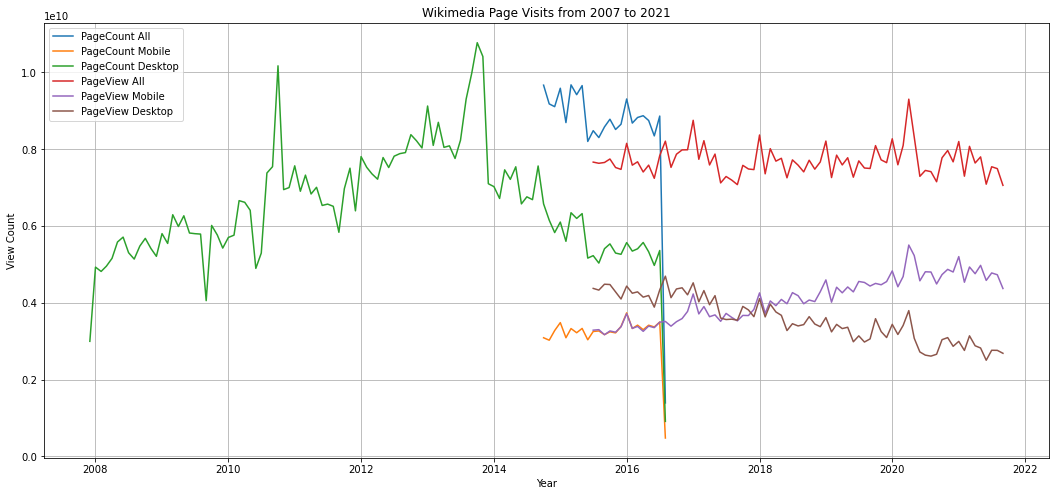

In [22]:
# Create a plot
plt.figure(figsize=(18, 8))

# Plotting the Page Counts
plt.plot(df.date, df.pagecount_all_views)
plt.plot(df.date, df.pagecount_mobile_views)
plt.plot(df.date, df.pagecount_desktop_views)

# Plotting the Page Views
plt.plot(df.date, df.pageview_all_views)
plt.plot(df.date, df.pageview_mobile_views)
plt.plot(df.date, df.pageview_desktop_views)

# Create a legend for the different lines that will be displayed
plt.legend(["PageCount All", "PageCount Mobile", "PageCount Desktop", "PageView All", "PageView Mobile", "PageView Desktop"])

# Formatting the time series graph
plt.xlabel("Year")
plt.ylabel("View Count")

plt.title("Wikimedia Page Visits from 2007 to 2021")
plt.grid()